In [1]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, GroupKFold
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


In [2]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [3]:
with open(proj_dir+"latent_space/2023-06-28T21-02-28_sae_kl_f32_ep70.pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [4]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

x = aggregate_embeddings

x = x.reshape(x.shape[0],-1)

In [5]:
print(x.shape)

(1588, 4096)


# Load Trip Behavior

In [6]:
file = "MyDailyTravel/origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)
y_ct = df_pivot['geoid'].to_list()
y = df_pivot[variable_names].to_numpy()[:,:4]

groups = df_pivot['train_test']
group_split = GroupKFold(n_splits=5)

In [7]:
if len(x) != len(y):
    x_mask = [True if c in y_ct else False for c in unique_ct]
    x = x[x_mask,:]
    unique_ct = list(np.array(unique_ct)[x_mask])
    y_mask = [True if c in unique_ct else False for c in y_ct]
    y = y[y_mask,:]
    y_ct = list(np.array(y_ct)[y_mask])

x = x[[y_ct.index(val) for val in unique_ct],:]
unique_ct = list(np.array(unique_ct)[np.array([y_ct.index(val) for val in unique_ct])])
for xc,yc in zip(unique_ct, y_ct):
    assert xc == yc

In [8]:
print(len(y))

1571


# 1. Linear Regression

### 1.1 Auto Share

In [10]:
y_index = 1

In [13]:
# Lasso
for a in (1e-3)*np.array([5,6,7,8,9,10]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-03, tolerance: 1.210e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e-03, tolerance: 1.286e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 5.00e-03 	 Train score: 0.5450 	 Cross val score: 0.4820 	 Nonzero coef: 53
Parameter: 6.00e-03 	 Train score: 0.5370 	 Cross val score: 0.4837 	 Nonzero coef: 42
Parameter: 7.00e-03 	 Train score: 0.5310 	 Cross val score: 0.4853 	 Nonzero coef: 38
Parameter: 8.00e-03 	 Train score: 0.5263 	 Cross val score: 0.4870 	 Nonzero coef: 33
Parameter: 9.00e-03 	 Train score: 0.5223 	 Cross val score: 0.4881 	 Nonzero coef: 30
Parameter: 1.00e-02 	 Train score: 0.5190 	 Cross val score: 0.4883 	 Nonzero coef: 28


### 1.2 PT

In [14]:
y_index = 3

In [15]:
# Lasso
for a in (1e-3)*np.array([5,6,7,8,9,10]):
# for a in (1e-4)*np.array([10,15,20,25,30,50]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-03, tolerance: 1.210e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e-03, tolerance: 1.286e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 5.00e-03 	 Train score: 0.5450 	 Cross val score: 0.4820 	 Nonzero coef: 53
Parameter: 6.00e-03 	 Train score: 0.5370 	 Cross val score: 0.4837 	 Nonzero coef: 42
Parameter: 7.00e-03 	 Train score: 0.5310 	 Cross val score: 0.4853 	 Nonzero coef: 38
Parameter: 8.00e-03 	 Train score: 0.5263 	 Cross val score: 0.4870 	 Nonzero coef: 33
Parameter: 9.00e-03 	 Train score: 0.5223 	 Cross val score: 0.4881 	 Nonzero coef: 30
Parameter: 1.00e-02 	 Train score: 0.5190 	 Cross val score: 0.4883 	 Nonzero coef: 28


### 1.3 Active

In [16]:
y_index = 0

In [17]:
# Lasso
for a in (1e-3)*np.array([5,6,7,8,9,10]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.246e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 5.00e-03 	 Train score: 0.6005 	 Cross val score: 0.5320 	 Nonzero coef: 90


/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.383e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 6.00e-03 	 Train score: 0.5899 	 Cross val score: 0.5334 	 Nonzero coef: 72


/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 7.00e-03 	 Train score: 0.5824 	 Cross val score: 0.5318 	 Nonzero coef: 59


/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.603e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 8.00e-03 	 Train score: 0.5763 	 Cross val score: 0.5307 	 Nonzero coef: 53


/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e-02, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 9.00e-03 	 Train score: 0.5710 	 Cross val score: 0.5294 	 Nonzero coef: 49


/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.113e-03, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.266e-03, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Parameter: 1.00e-02 	 Train score: 0.5666 	 Cross val score: 0.5282 	 Nonzero coef: 44


# 2. MNL for Mode Share

In [11]:
results = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}}


In [18]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [1e-5]
wd_list = [1e+6]#100, 1000, 10000, 100000]


for i in range(5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], sst_train, sst_test, lr_list=lr_list, wd_list=wd_list,
                         save_models=True,
                         save_name='SAE+(4096)_0.9_'+str(i))
    
    results[i].update(ret_dict)

[lr: 1.00e-05, wd: 1.00e+06]
Early stopping at epoch 2230
[epoch: 2220] Train KL loss: 0.139 Train R2 score: 0.487 0.599 -0.056 0.451 
[epoch: 2220] Test KL loss: 0.141 Test R2 score: 0.508 0.609 -0.060 0.489 

[lr: 1.00e-05, wd: 1.00e+06]
Early stopping at epoch 1920
[epoch: 1910] Train KL loss: 0.136 Train R2 score: 0.503 0.590 -0.027 0.463 
[epoch: 1910] Test KL loss: 0.153 Test R2 score: 0.420 0.551 -0.027 0.386 

[lr: 1.00e-05, wd: 1.00e+06]
Early stopping at epoch 2300
[epoch: 2290] Train KL loss: 0.141 Train R2 score: 0.499 0.603 -0.062 0.447 
[epoch: 2290] Test KL loss: 0.137 Test R2 score: 0.455 0.563 -0.132 0.459 

[lr: 1.00e-05, wd: 1.00e+06]
Early stopping at epoch 2280
[epoch: 2270] Train KL loss: 0.142 Train R2 score: 0.471 0.583 -0.097 0.460 
[epoch: 2270] Test KL loss: 0.135 Test R2 score: 0.549 0.602 -0.202 0.467 

[lr: 1.00e-05, wd: 1.00e+06]
Early stopping at epoch 2290
[epoch: 2280] Train KL loss: 0.139 Train R2 score: 0.493 0.596 -0.064 0.456 
[epoch: 2280] Test KL

In [20]:
df = []
lr_list = [1e-5]
wd_list = [100, 1000, 10000, 100000, 1e+6]

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            if k != 'train_loss' and k != 'test_loss':
                new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))

pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss').round(5)

,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
3,0.00001,100000.0,0.12800,0.13301,0.63690,0.54027,0.50422,0.61849,0.52042,0.47013
2,0.00001,10000.0,0.12182,0.13386,0.65927,0.57494,0.50862,0.61415,0.51637,0.42451
1,0.00001,1000.0,0.10762,0.13591,0.71478,0.64023,0.60870,0.60981,0.50734,0.43730
4,0.00001,1000000.0,0.13968,0.14234,0.59431,0.49056,0.45535,0.58086,0.47705,0.44936
0,0.00001,100.0,0.09348,0.14449,0.76692,0.70654,0.67009,0.58845,0.46642,0.36320


(0.0, 0.2)

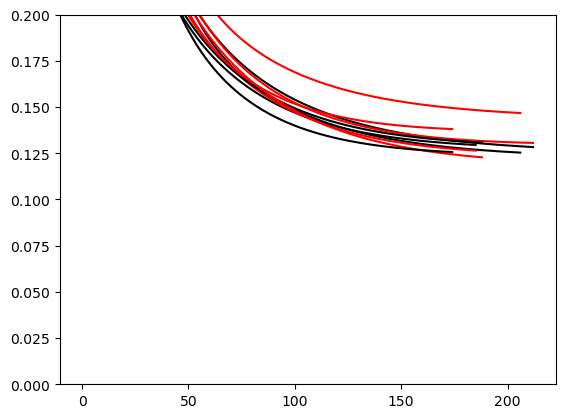

In [17]:
lr = 1e-5
wd = 100000
for i in range(5):
        plt.plot(results[i][(lr, wd)]['train_loss'], c='black')
        plt.plot(results[i][(lr, wd)]['test_loss'], c='red')
plt.ylim([0,0.2])